In [1]:
%autosave 0

Autosave disabled


## Contents
1. **Data: the Tables.** <br> _Outlook on raw data._
2. **Data arrangments.** <br> _Here, dataset for each group is derived from the original tables data._
3. **Outlook on product groups.** <br> _Meanigful outlook on product groups._
4. **Modeling and evaluation.** <br> _Forecasts are generated here in order to evaluate different approaches (Prophet, HoltWinters, ML) for product groups._
5. **Forecasting for product groups** <br> _Plotting some forecasts vs actuals and forecasting into the future._

### Notes

NOTE: Elaborated ML part of this notebook (section 4.3) took 4.5h to compute on cpu i5 (9gen). So, just please be aware. 

Besides classic Holt-Winters and sophisticated ML approach, Facebook's Prophet model has also been added to consideration. The reason is that it is quick, one can throw everything at it (can digest everything in terms of stationarity/seasonality etc.) and, usually, produce results of highest quality. 

Please also note that forecast horion has been streached to 21 days, instead of 14, due to technical reasons. Many forecast errors are calculated throughout this notebook and 21 sample points instead of 14 is a bare minimum to make these errors reliable. 

In [2]:
import numpy as np
import pandas as pd
import time

# 1) Data: the Tables. 
Outlook on what our raw data actually looks like. Some preprocessing like NaN issues, indexing or feature extraction are also done here.

In [3]:
orders = pd.read_csv('orders.csv')
order_items = pd.read_csv('order_items.csv')
products = pd.read_csv('products.csv')

## 1.1) Orders

#### Orders overview

In [4]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


#### Orders preprocessing

In [6]:
# we will assume order_purchase_timestamp as actual transaction date
orders.order_purchase_timestamp = pd.to_datetime(orders['order_purchase_timestamp'])
orders.set_index('order_purchase_timestamp', inplace=True)
orders.sort_index(inplace=True)
# we will be intrested only in delivered orders in our considerations
orders = orders[orders.order_status == "delivered"]

## 1.2) Order intems

#### Order items overview

In [7]:
order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [8]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


## 1.3) Products

#### Products overwiev

In [9]:
products.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [10]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


#### Products preprocessing

In [11]:
# missing categories are treated as a category of its own
products.product_category_name = products.product_category_name.fillna('NaN')

In [12]:
# we will add a column associated with the volume of the product; later we might want predict volume of products instead of value with a little tweak of the code 
dimentions = ['product_length_cm','product_height_cm','product_width_cm']
products['product_volume'] = products[dimentions].prod(axis=1)

# 2) Data arrangments
In this section, dataset for each group is derived from the original tables data.

We are tasked with forecasting for each product category. Therefore, a dictionary called 'categories' is created, where each key corresponds to a product category (group). The dictionary will serve as a container for dataset dedicated for any given group. 

In [13]:
categories = {}

# this timespan has been directly derived from orders.order_purchase_timestamp
start_date = '2016-09-15'
end_date = '2018-08-29'
datetime_index = pd.date_range(start=start_date, end=end_date, freq='D')

# these are the options how one can understand 'demand' in this task, by default 'value' will be adopted.
column_names = ['value','volume','items_qty']

for category in products.product_category_name.unique():
    categories[category] = pd.DataFrame(0, index=datetime_index, columns=column_names)

Now with our desired data container created, we need to cycle through our orders one by one, retrieve all information we want and then update accordingly the values of dataframes stored in the 'categories' dictionary.

In [14]:
%%time
for index, row in orders.iterrows():
    for item in order_items[order_items.order_id == row.order_id].iterrows():
        group = products[products.product_id == item[1].product_id].product_category_name.iloc[0]
        categories[group].items_qty[index.strftime('%Y-%m-%d')] += 1
        categories[group].volume[index.strftime('%Y-%m-%d')] += products[products.product_id == item[1].product_id].product_volume.iloc[0]
        categories[group].value[index.strftime('%Y-%m-%d')] += item[1].price

<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/petewojtczak/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

CPU times: user 21min 56s, sys: 125 ms, total: 21min 56s
Wall time: 21min 56s


# 3) Outlook on product groups
After all work done so far, in this section we can finally have a sense of product categories and their importance in the business.  

Dataframe 'categories_summary' is created for displaying summarized information in a concise manner.

In [15]:
keys = list(categories.keys())
categories_summary = pd.DataFrame(0, index=keys, columns=['total_items_sold','value','data_absence_count'])

for key in categories.keys():
    categories_summary.loc[key].data_absence_count = (categories[key] == 0).all(axis=1).sum()
    categories_summary.loc[key].total_items_sold = categories[key].items_qty.sum()
    categories_summary.loc[key].value = categories[key].value.sum()
categories_summary['data_absence_share'] = categories_summary.data_absence_count/714

#### Most valuable categories

In [16]:
categories_summary = categories_summary.sort_values(by='value', ascending=False)
categories_summary.head(15)

,total_items_sold,value,data_absence_count,data_absence_share
beleza_saude,9465,1233131,112,0.156863
relogios_presentes,5859,1166176,143,0.200280
cama_mesa_banho,10953,1023434,117,0.163866
esporte_lazer,8431,954852,111,0.155462
informatica_acessorios,7644,888724,121,0.169468
moveis_decoracao,8160,711927,110,0.154062
utilidades_domesticas,6795,615628,128,0.179272
cool_stuff,3718,610204,130,0.182073
automotivo,4140,578966,135,0.189076
brinquedos,4030,471286,125,0.175070


#### Least valuable categories

For contrast, below 10 least valuable categories are listed. 

In [17]:
categories_summary.tail(10)

,total_items_sold,value,data_absence_count,data_absence_share
fashion_esporte,29,2094,688,0.963585
la_cuisine,14,2054,701,0.981793
artes_e_artesanato,24,1814,693,0.970588
fraldas_higiene,37,1500,689,0.964986
pc_gamer,8,1306,707,0.990196
flores,33,1110,687,0.962185
casa_conforto_2,30,760,691,0.967787
cds_dvds_musicais,14,730,702,0.983193
fashion_roupa_infanto_juvenil,7,519,707,0.990196
seguros_e_servicos,2,283,712,0.997199


# 4) Modeling and evaluation
In this section, forecasts are generated in order to evaluate different approaches (Prophet, HoltWinters, ML) for product groups. Forecasting errors are added to (or stored in) 'categories_summary' dataframe for further inspection.

#### Sparsity and Modeling
Given the dataframe printed out above (categories_summary.tail), it is very much clear that not all product groups will make it to the modeling phase. There is virtually no market for some categories and a very, very rough rule is 10-20 sample points for an estimated parameter. In cases of data sparsity, tricks like resampling (aggregationg over longer period) or imputation methods can be helpful. We will not dwell on that, however, and rather focus on the 14 most valuable categories instead (as herein lies the core of the business). Due to data sparsity we were forced to cut it somewhere and there is still plenty to compute anyway.

In [18]:
# this is new dictionary carring data with our 14 most valuable categories
categories_dict = {key: value for key, value in categories.items() if key in categories_summary.head(14).index}

In [19]:
# We will update summarization dataframe accordingly as well
categories_summary = categories_summary.head(14)

## 4.1) Prophet (Kats)
Benchmark solution. Can basically digest any time-series and be used instantly. Very quick and reliable.

In [20]:
categories_summary['Prophet_RMSE'] = 0
categories_summary['Prophet_MAE'] = 0

In [21]:
# Here is our choice of metrics and it is valid throughout the notebbok
def evaluation_metrics(y_test, y_pred):
    RMSE = np.mean((y_pred - y_test)**2)**.5  
    MAE = np.mean(np.abs(y_test - y_pred))
    return({'RMSE':round(RMSE,3), 'MAE':round(MAE,3)})

In [22]:
%%time
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

for key in categories_dict.keys():
    
    # data preparation
    ts = categories_dict[key].value
    ts = pd.DataFrame(ts)
    ts.reset_index(inplace=True)
    ts.columns = ['time','value']
    kats_ts = TimeSeriesData(ts)
    
    # train/test split 
    y_train = kats_ts[:len(kats_ts)-21]
    y_test = ts[len(kats_ts)-21:]
    
    # training
    params = ProphetParams()
    m = ProphetModel(y_train, params)
    m.fit()
    
    # forecasting
    fcst = m.predict(steps=21, freq="D")
    
    # Evaluation
    fcst.set_index('time', inplace=True)
    y_test.set_index('time', inplace=True)
    evaluation_df = fcst.assign(y_test=y_test['value'])
    metrics = evaluation_metrics(evaluation_df['y_test'], evaluation_df['fcst'])
    categories_summary.loc[key, 'Prophet_RMSE'] = metrics['RMSE']
    categories_summary.loc[key, 'Prophet_MAE'] = metrics['MAE']

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

CPU times: user 19.6 s, sys: 308 ms, total: 19.9 s
Wall time: 21 s


## 4.2) Holt-Winters (Kats)
Holt-Winters can cope with trend and seasonality, if specified.

In [23]:
categories_summary['HoltWinters_RMSE'] = 0
categories_summary['HoltWinters_MAE'] = 0

In order to use this model, we need to be sure about the type of periodicity in our data. The below output makes it clear that the businnes works in weekly rythym. We will also asusume additive trend.

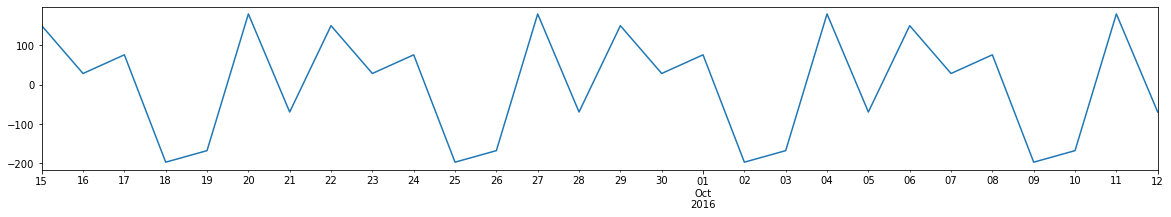

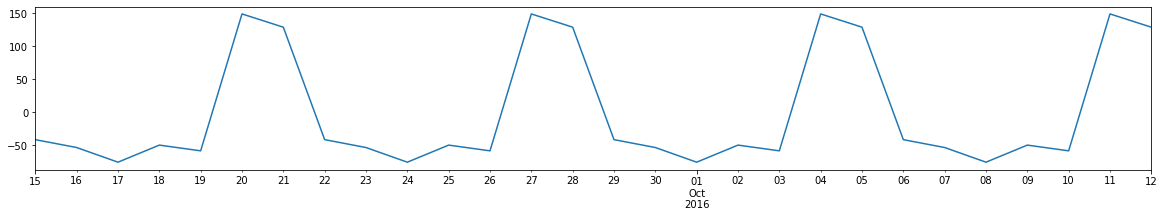

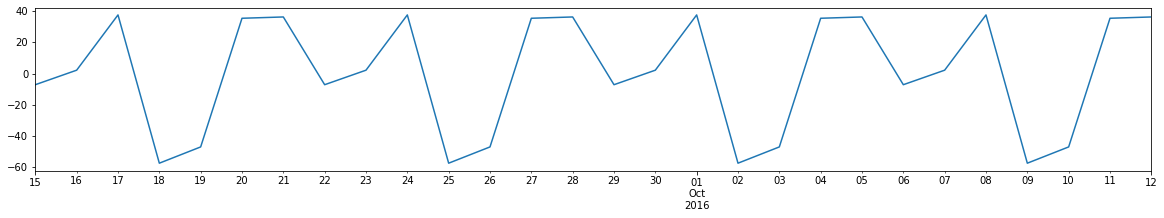

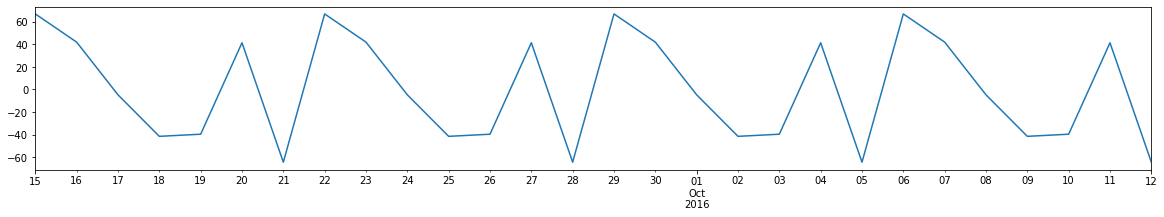

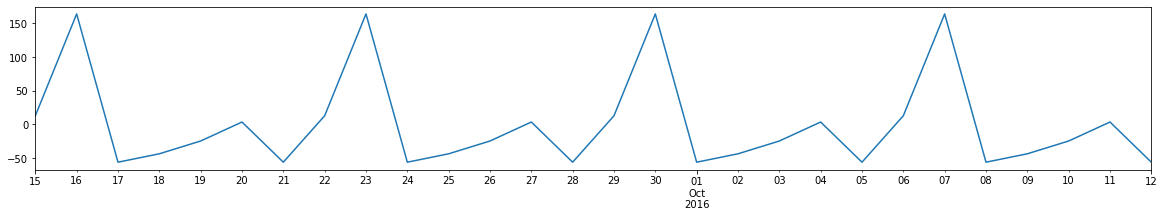

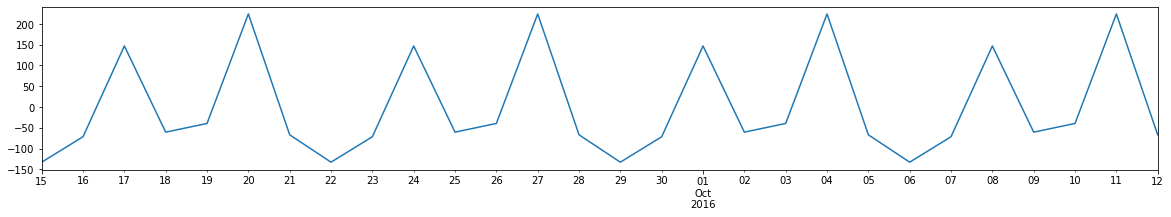

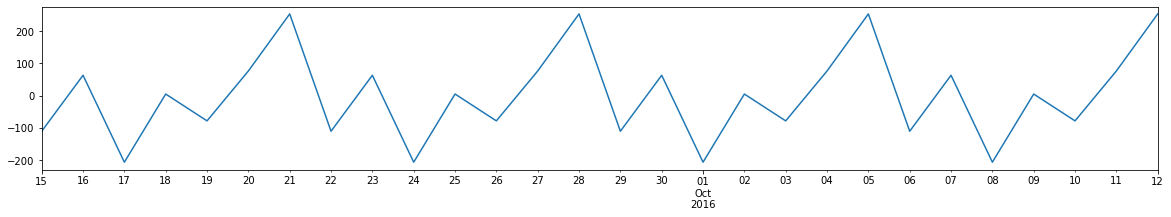

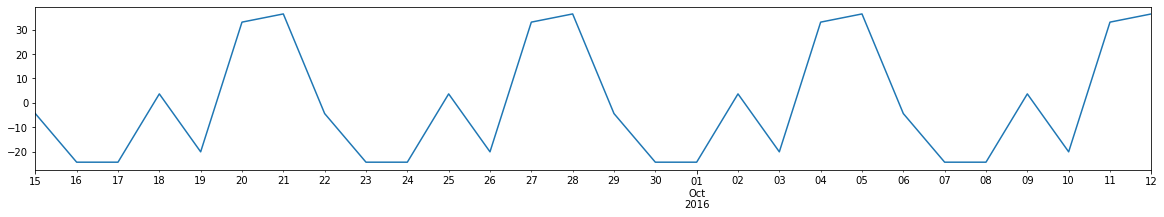

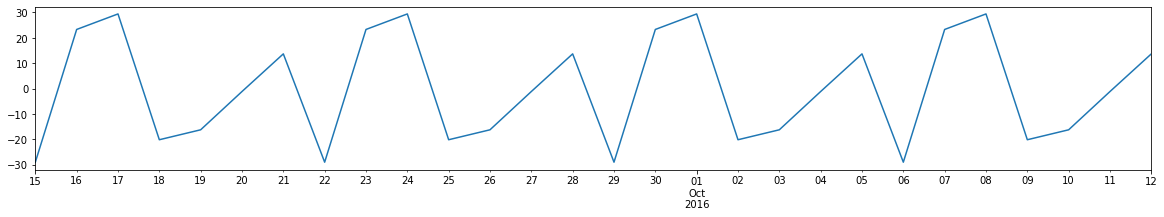

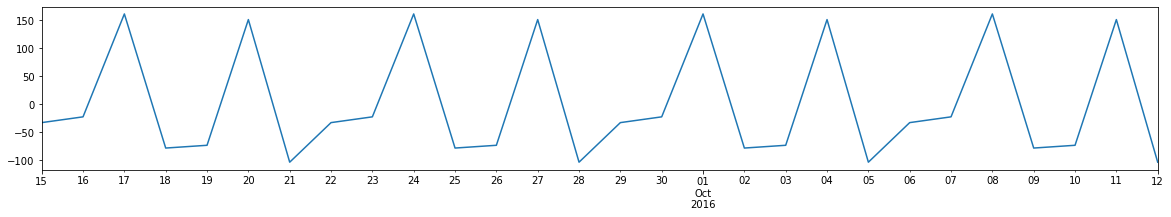

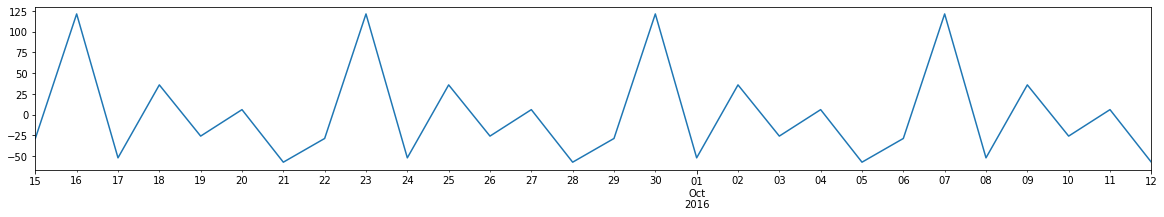

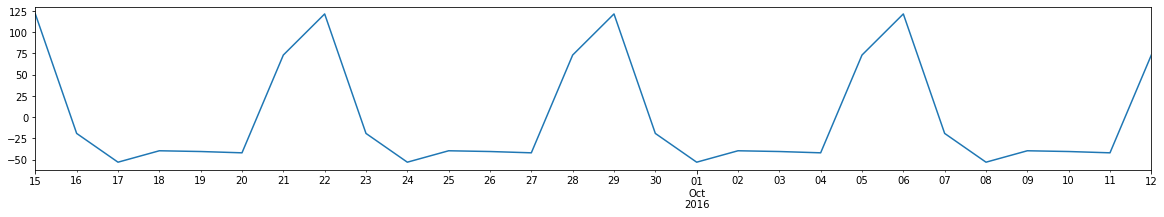

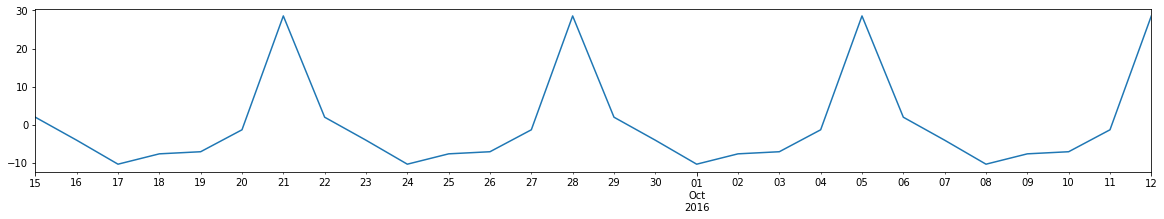

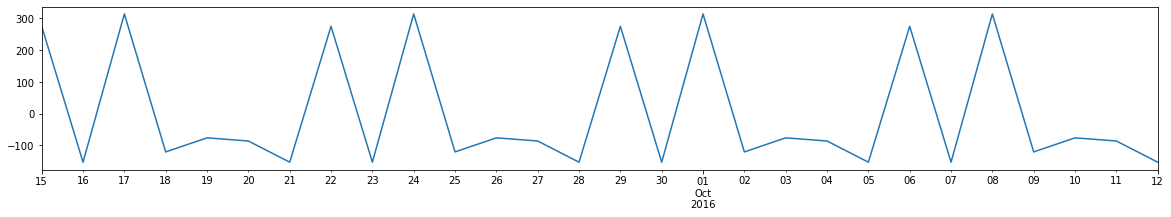

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib inline

for key in categories_dict.keys():
    ts = categories_dict[key].value
    magified_seasonality = ts.iloc[0:28]
    magified_seasonality.asfreq('D')
    decomp = seasonal_decompose(magified_seasonality)
    decomp.seasonal.plot()
    plt.gcf().set_size_inches(20, 3)
    plt.show()

In [25]:
%%time
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel

for key in categories_dict.keys():
    
    # data preparation
    ts = categories_dict[key].value
    ts = pd.DataFrame(ts)
    ts.reset_index(inplace=True)
    ts.columns = ['time','value']
    kats_ts = TimeSeriesData(ts)
    
    # train/test split 
    y_train = kats_ts[:len(kats_ts)-21]
    y_test = ts[len(kats_ts)-21:]
    
    # training    
    params = HoltWintersParams(trend="add", damped=False, seasonal_periods=7)
    m = HoltWintersModel(data=y_train, params=params)
    m.fit()

    # forecasting
    fcst = m.predict(steps=21, freq="D")
    
    # Evaluation
    fcst.set_index('time', inplace=True)
    y_test.set_index('time', inplace=True)
    evaluation_df = fcst.assign(y_test=y_test['value'])
    metrics = evaluation_metrics(evaluation_df['y_test'], evaluation_df['fcst'])
    categories_summary.loc[key, 'HoltWinters_RMSE'] = metrics['RMSE']
    categories_summary.loc[key, 'HoltWinters_MAE'] = metrics['MAE']

/home/petewojtczak/anaconda3/lib/python3.8/site-packages/kats/models/holtwinters.py:129: FutureWarning:

the 'damped'' keyword is deprecated, use 'damped_trend' instead

/home/petewojtczak/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/petewojtczak/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/petewojtczak/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/petewojtczak/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/petewojtczak/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization faile

CPU times: user 441 ms, sys: 1 µs, total: 441 ms
Wall time: 443 ms


/home/petewojtczak/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



For some categories (7 out of 14), optimization failed to converge and for these categories further research would be need if Holt-Winters is desired.

## 4.3) Machine Learning (sklearn with sktime)
One thing about our problem is that it can be reframed to a regression problem through the process of data tabularization. Here, we leverage sktime toolkit and for every category we employ a forecasting gridsearch tool in order to find the best set of parameters for two sklearn regressors: GradientBoostingRegressor and RandomForestRegressor. When these are found, we compare both models' forcasting performance; the better one for a given category is then again refitted with whole data (y_test included) and saved into the dictionary 'models' so that it is ready to make future forecasts.

Please note that ExpandingWindowSplitter is used to perform cross-validation while the forecasting grid search is performed. 

In [26]:
categories_summary['ML_RMSE'] = 0
categories_summary['ML_MAE'] = 0

In [27]:
# here is our parameter search space for each regressor
hypergrid = {
    'gbr': {
        "estimator__learning_rate":[0.01, 0.1, 0.5],
        "estimator__warm_start":[True, False]        
    },
    'RandForest': {
        "estimator__n_estimators":[30, 50, 100, 150],
        "estimator__warm_start":[True, False]
    }
}

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# here are our regressors
regressors = {
    'gbr': GradientBoostingRegressor(),
    'RandForest': RandomForestRegressor(criterion='absolute_error'),
}

In [29]:
# for every category, model space is researched using ForecastingGridSearchCV and ExpandingWindowSplitter and best model is refitted with whole data and saved. 
%%time
# tabularization
from sktime.forecasting.compose import make_reduction
# forecst horizon
from sktime.forecasting.base import ForecastingHorizon
# hypertuning
from sktime.forecasting.model_selection import (ForecastingGridSearchCV,ExpandingWindowSplitter)
# metric
from sktime.performance_metrics.forecasting import MeanAbsoluteError

# container for refitted saved models; keys are categories, and values are best ML model found for this category
models = {}

for key in categories_dict.keys():
    
    # data preparation
    ts = categories_dict[key].value
    ts = pd.DataFrame(ts)
    
     # train/test split 
    y_train = ts.iloc[:len(ts)-21]
    y_test = ts.iloc[len(ts)-21:]
    y_train = y_train.asfreq('D')
    
    # training
    fit_models = {}
    for algo in regressors.keys():
        regressor = regressors[algo]
        forecaster = make_reduction(regressor, strategy="direct", window_length=7)  # Since we have weekly seasonality, window_length for tabularization is 7
        fh_cv=ForecastingHorizon(np.arange(1, 22))
        cv = ExpandingWindowSplitter(fh=fh_cv, initial_window=int(len(y_train) - 105), step_length=21)  # cross-validation using ExpandingWindowSplitter will have 5 steps
        fgscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=hypergrid[algo], scoring=MeanAbsoluteError())
        fh=ForecastingHorizon(np.arange(1, 22))
        fgscv.fit(y_train, fh=fh)
        fit_models[algo]=fgscv
    
    # Forecasting and evaluating
    first_algo = True
    for algo in regressors.keys():
        if first_algo == True:
            y_pred = fit_models[algo].predict(fh)
            algo_MAE = np.mean(np.abs(y_test - y_pred)).value
            algo_RMSE = (np.mean((y_pred - y_test)**2)**.5).value
            best_MAE = algo_MAE
            best_RMSE = algo_RMSE
            best_algo = algo
            first_algo = False
            continue
        y_pred = fit_models[algo].predict(fh)
        algo_MAE = np.mean(np.abs(y_test - y_pred)).value
        algo_RMSE = (np.mean((y_pred - y_test)**2)**.5).value
        if algo_MAE < best_MAE:
            best_MAE = algo_MAE
            best_RMSE = algo_RMSE
            best_algo = algo
    categories_summary.loc[key, 'ML_RMSE'] = best_RMSE
    categories_summary.loc[key, 'ML_MAE'] = best_MAE
    
    # Refitting with all data (y_test included)
    y_train = ts
    y_train = y_train.asfreq('D')
    regressor = regressors[best_algo]
    forecaster = make_reduction(regressor, strategy="direct", window_length=7)
    fh_cv=ForecastingHorizon(np.arange(1, 22))
    cv = ExpandingWindowSplitter(fh=fh_cv, initial_window=int(len(y_train) - 105), step_length=21)
    fgscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=hypergrid[best_algo], scoring=MeanAbsoluteError())
    fh=ForecastingHorizon(np.arange(1, 22))
    fgscv.fit(y_train, fh=fh)
    
    # Saving the best ML model into the dictionary for future use
    models[key] = fgscv

CPU times: user 4h 29min 25s, sys: 7.72 s, total: 4h 29min 33s
Wall time: 4h 29min 32s


## 4.4) Modeling and evaluation summary

In [30]:
categories_summary

,total_items_sold,value,data_absence_count,data_absence_share,Prophet_RMSE,Prophet_MAE,HoltWinters_RMSE,HoltWinters_MAE,ML_RMSE,ML_MAE
beleza_saude,9465,1233131,112,0.156863,1897.982,1453.164,2395.126,1921.561,1730.173325,1459.162079
relogios_presentes,5859,1166176,143,0.200280,2222.352,1891.098,2171.958,1840.251,1502.845491,1266.706769
cama_mesa_banho,10953,1023434,117,0.163866,1201.083,932.622,1539.432,1271.237,1104.884425,888.132125
esporte_lazer,8431,954852,111,0.155462,1786.618,1107.934,1834.648,1284.477,1866.117800,1215.842972
informatica_acessorios,7644,888724,121,0.169468,802.835,651.255,1296.616,1132.914,1102.922537,949.229492
moveis_decoracao,8160,711927,110,0.154062,1002.672,822.952,1224.944,1056.078,777.286542,611.317469
utilidades_domesticas,6795,615628,128,0.179272,1457.605,1152.676,1758.743,1528.262,1510.237359,1164.264357
cool_stuff,3718,610204,130,0.182073,399.349,335.308,563.176,510.856,681.896954,620.360229
automotivo,4140,578966,135,0.189076,1385.637,1105.365,1471.726,1242.082,1368.528960,966.334854
brinquedos,4030,471286,125,0.175070,310.442,248.267,541.432,487.352,453.627785,375.931837


# 5) Forecasting for product groups
Forecasting with best approach for a category.

In [31]:
# mean MAE is calculated across categories 
categories_summary['Prophet_MAE'].mean(), categories_summary['HoltWinters_MAE'].mean(), categories_summary['ML_MAE'].mean()

(870.9127857142859, 1093.9098571428572, 819.9690094882887)

In general, ML solution works best. No single category is best forecasted by HoltWinters as it has been outperformed by competition and some further research would be needed to possibly make it work.

## Forecasting with Prophet model

If we are intrested in forecasting for category 'brinquedos' it is the Prophet model that seems to be the best choice in terms of erros.

In [32]:
categories_summary.loc['brinquedos']

total_items_sold        4030.000000
value                 471286.000000
data_absence_count       125.000000
data_absence_share         0.175070
Prophet_RMSE             310.442000
Prophet_MAE              248.267000
HoltWinters_RMSE         541.432000
HoltWinters_MAE          487.352000
ML_RMSE                  453.627785
ML_MAE                   375.931837
Name: brinquedos, dtype: float64

### Plotting forecasts vs actuals

But first, let's actually plot some forecasts against actuals in order to get a better sense of how the model is performing.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


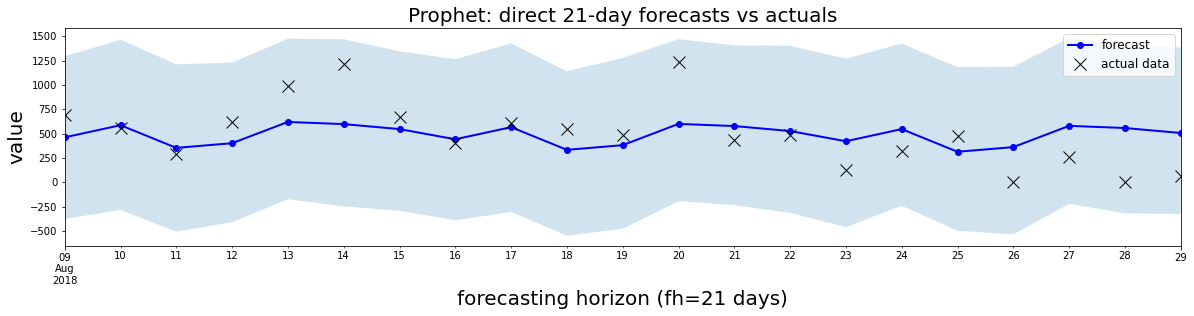

CPU times: user 1.48 s, sys: 8 ms, total: 1.49 s
Wall time: 1.49 s


In [33]:
%%time
# generating forecasts for plotting
ts = categories_dict['brinquedos'].value 
ts = pd.DataFrame(ts)
ts.reset_index(inplace=True)
ts.columns = ['time','value']
kats_ts = TimeSeriesData(ts)
y_train = kats_ts[:len(kats_ts)-21]
y_test = ts[len(kats_ts)-21:]

params = ProphetParams()
m = ProphetModel(y_train, params)
m.fit()

fcst = m.predict(steps=21, freq="D")
fcst.set_index('time', inplace=True)
y_test.set_index('time', inplace=True)
evaluation_df = fcst.assign(y_test=y_test['value'])

# plotting
plt.figure()
evaluation_df['fcst'].plot(label='forecast', color='blue', marker='o', linewidth=2)
evaluation_df['y_test'].plot(label='actual data', color='black', marker='x', markersize=12, linestyle='None')
plt.fill_between(evaluation_df.index, evaluation_df['fcst_lower'], evaluation_df['fcst_upper'], alpha=0.2)
plt.title('Prophet: direct 21-day forecasts vs actuals', size=20)
plt.xlabel('forecasting horizon (fh=21 days)', size=20)
plt.ylabel('value', size = 20)
plt.gcf().set_size_inches(20, 4)
plt.legend(loc=1, prop={'size': 12})
plt.show()

Metrics associated with this forecast are actually the metrics found in categories_summary, where we evaluated performences for each category.

In [34]:
metrics = evaluation_metrics(evaluation_df['y_test'], evaluation_df['fcst'])
metrics

{'RMSE': 310.442, 'MAE': 248.267}

### Forecasting into the future with Prophet

We would need to refit again the model for whole dataset in order to produce the acual forecasts.

In [35]:
ts = categories_dict['brinquedos'].value 
ts = pd.DataFrame(ts)
ts.reset_index(inplace=True)
ts.columns = ['time','value']
y_train = TimeSeriesData(ts)

params = ProphetParams()
m = ProphetModel(y_train, params)
m.fit()

fcst = m.predict(steps=21, freq="D")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
fcst.set_index('time', inplace=True)
fcst

,fcst,fcst_lower,fcst_upper
time,,,
2018-08-30,400.550717,-468.070363,1180.162719
2018-08-31,524.203262,-380.267613,1355.369295
2018-09-01,296.401422,-557.537833,1072.706535
2018-09-02,340.744341,-471.435398,1226.834241
2018-09-03,566.285868,-252.625652,1369.390429
2018-09-04,536.524458,-240.135461,1334.482143
2018-09-05,482.690133,-307.316479,1327.246942
2018-09-06,380.348458,-516.910604,1159.769922
2018-09-07,504.001004,-360.848112,1307.344219


## Forecasting with ML model

Lets say our category of focus is 'bebes'.

In [37]:
categories_summary.loc['bebes']

total_items_sold        2982.000000
value                 400421.000000
data_absence_count       153.000000
data_absence_share         0.214286
Prophet_RMSE             809.011000
Prophet_MAE              754.537000
HoltWinters_RMSE         743.308000
HoltWinters_MAE          680.952000
ML_RMSE                  550.496018
ML_MAE                   467.242339
Name: bebes, dtype: float64

Forecasting into the future with ML model could not have been made easier - best ML model for each category is stored in dedicated dictionary. Models are refitted with whole dataset after evaluation and will produce the actual forecast for 21 days.

In [38]:
models['bebes'].predict(fh)

,value
2018-08-30,288.228398
2018-08-31,356.191860
2018-09-01,342.952442
2018-09-02,444.954453
2018-09-03,376.695850
2018-09-04,315.948126
2018-09-05,493.375835
2018-09-06,353.773969
2018-09-07,434.814217
2018-09-08,364.475858


Here are essential details about the actual best ML model found for this particular category.

In [39]:
models['bebes'].best_forecaster_

DirectTabularRegressionForecaster(estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                                      warm_start=True),
                                  window_length=7)